In [2]:
import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats

In [50]:
npath = ''
#cpath = '/Users/Clara Escanuela/OneDrive/Escritorio/MPhys_project/root_files/'
cpath = '/Users/Clara Escanuela/Downloads/'

path = cpath

def optim_bins(mult_arry):
    
    #import astropy
    #from astropy import stats
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        #print(arry)
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['event_tree']
    rTree_data = rTree['data_tree']
    #rTree_vuv = rTree['data_tree_vuv']
    
    event_x_pos = np.array(rTree_event['event_x_pos'])
    event_E = np.array(rTree_event['event_E'])

    data_event = np.array(rTree_data['data_event'])
    #data_pmt = np.array(rTree_data['data_pmt'])
    data_time = np.array(rTree_data['data_time']) 

    data_index, count_scint = np.unique(data_event, return_counts=True)
    #split_pmt = np.split(data_pmt, np.cumsum(count_scint)) 
    split_time = np.split(data_time, np.cumsum(count_scint))

    return split_time, count_scint, event_x_pos, event_E

import itertools 
#from itertools import izip

def pairwise(iterable):
    "s -> (s0,s1), (s2,s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

fname_sig = 'events_b8_foils_40.root'
fname_bkg = 'events_alphagamma_foils_40.root'

sig_split_time, sig_scint, sig_x, sig_event_E = root_input(path, fname_sig) 
bkg_split_time, bkg_scint, bkg_x, bkg_event_E = root_input(path, fname_bkg)  

#########################


bkg_split_time_temp = []
for x, y in pairwise(bkg_split_time):
    bkg_split_time_temp.append(np.append(x,y))
    
bkg_split_time = bkg_split_time_temp

In [51]:

########################################
# corrects for events lost, it is assumed that these are not simulated
# remember to add new event_index range, and change variable name of old event_index

def miss_correc(event_E, event_x, event_index, data_index):
    miss_index = np.setdiff1d(event_index, data_index)  #event indexes that are lost
    print(miss_index)

    for element in miss_index: 
        #print(element)
        event_E = event_E[event_index != element]
        event_x = event_x[event_index != element]
        event_index = event_index[event_index != element]
        
    return event_E, event_x, event_index

#event_E, event_x, event_index = miss_correc(event_E, event_x, event_index, data_index)

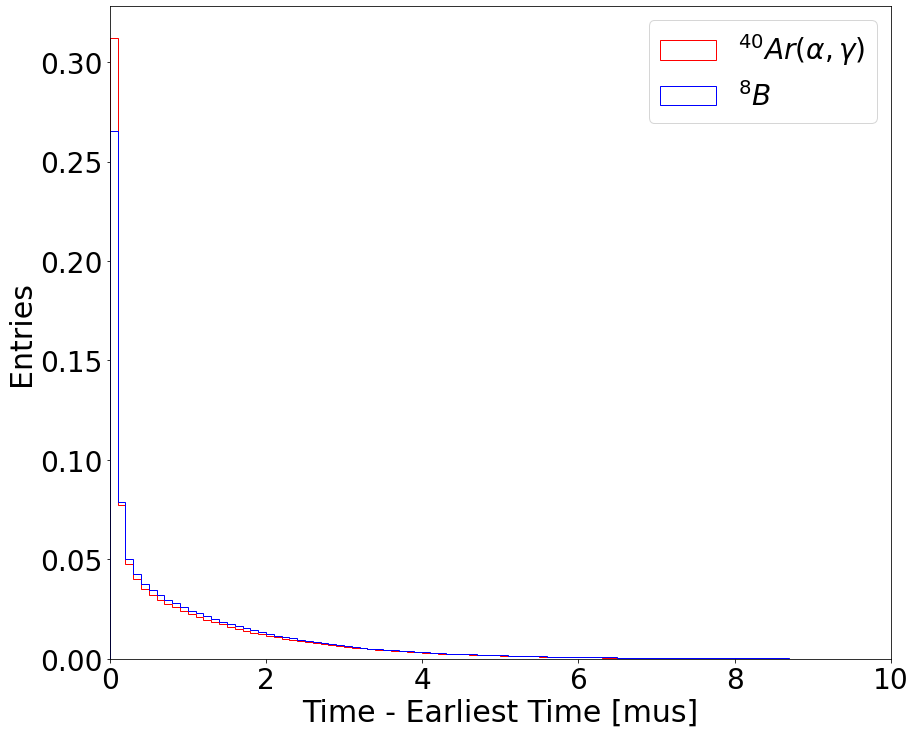

In [64]:
# Plot time distribution

data = [np.concatenate(sig_split_time), np.concatenate(bkg_split_time)]
rates = [1, 1] # normalise

num_bins = 200


labels = [r'${}^8 B$', r'${}^{40} Ar(\alpha, \gamma)$']
colors = ['blue', 'red']

plt.figure(figsize=(14,12))

n, bins, patches = plt.hist(data, stacked = False, color=colors, bins=int(10/0.1), range=[0, 10], label=labels, histtype='step', weights=hist_weights(rates, data))

plt.xlabel('Time - Earliest Time [mus]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Entries',fontsize=30)
plt.yticks(fontsize=28)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
plt.xlim(0, 10)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

In [53]:
#Optimize time time window

bin_width = bins[1] - bins[0]

max_diff = 0
max_i = 0

total_integralS = bin_width*sum(n[0])
print(total_integralS)

total_integral_bkg = bin_width*sum(n[1])
print(total_integral_bkg)

ratioS_array = np.array([])
ratio_bkg_array = np.array([])
    
for i in range(0, num_bins):
    integralS = bin_width * sum(n[0][0:i])
    integral_bkg = bin_width * sum(n[1][0:i])
    ratioS = integralS/total_integralS   #fast to total ratio for signal
    ratioS_array = np.append(ratioS_array, ratioS)
    ratio_bkg = integral_bkg/total_integral_bkg   #fast to total ration for bkg
    ratio_bkg_array = np.append(ratio_bkg_array, ratio_bkg)
    diff = abs(ratioS - ratio_bkg)
    if diff>max_diff:
        max_diff = diff
        max_i = i

print(max_i*100)   #Optimal time window (ns). Each bin: 0.1 mu sec.
max_time = max_i*100
print(max_diff)

0.09999554136060179
0.09999614097434378
100
0.047189705868935394


C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_12500/390135355.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return (np.sqrt(np.mean(data1**2)) - np.sqrt(np.mean(data2**2)))**2 / (np.var(data1) + np.var(data2))**2


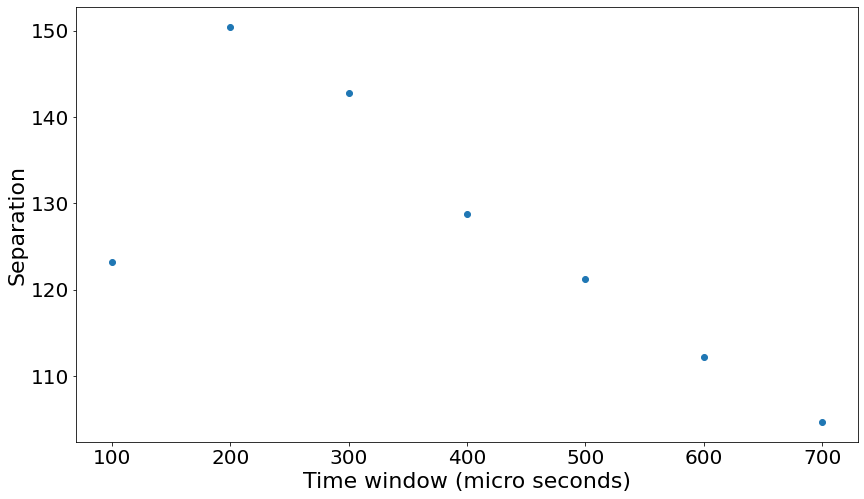

In [54]:
#Fprompt


def Fprompt(split_time, time):

    fprompt = np.array([])

    for event in split_time:
        if event.size > 0:
            fprompt = np.append(fprompt, len(event[event <= time*0.001])/len(event))
            
    return fprompt

#########################

def sep_func(data1, data2): # separation
    return (np.sqrt(np.mean(data1**2)) - np.sqrt(np.mean(data2**2)))**2 / (np.var(data1) + np.var(data2))**2


time_array = np.arange(0, 800, 100)
sep_array = np.array([])

np.concatenate(sig_split_time), np.concatenate(bkg_split_time)

for set_time in time_array:
    Fprompt_sig_temp = Fprompt(sig_split_time, set_time)
    Fprompt_bkg_temp = Fprompt(bkg_split_time, set_time)
    sep = sep_func(Fprompt_sig_temp, Fprompt_bkg_temp)
    sep_array = np.append(sep_array, sep) 

# optimises time window by calc separation between signal and background 

plt.figure(figsize=(14,8))
plt.scatter(time_array, sep_array)

plt.ylabel('Separation',fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel('Time window (micro seconds)',fontsize=22)
plt.xticks(fontsize=20)

plt.show()


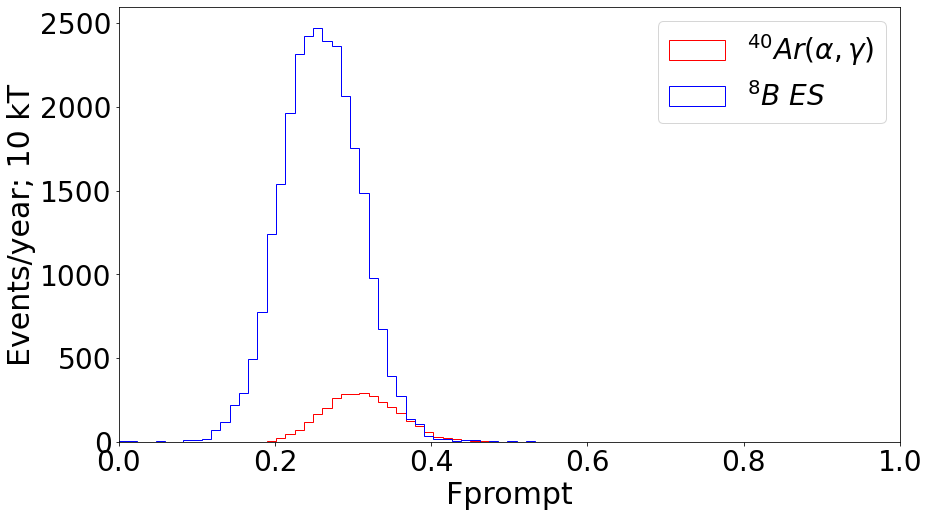

In [65]:
max_time = max_time

###########################

Fprompt_sig = Fprompt(sig_split_time, max_time)
Fprompt_bkg = Fprompt(bkg_split_time, max_time)


rates = [26700, 3000] # normalise

data = [Fprompt_sig, Fprompt_bkg]


labels = [r'${}^8 B\ ES$', r'${}^{40} Ar(\alpha, \gamma)$']
colors = ['blue', 'red']

plt.figure(figsize=(14,8))
bins=60

n_, bins_, patches_ = plt.hist(data, stacked = False, weights=hist_weights(rates, data), color=colors, bins=bins, label=labels, histtype='step')

plt.xlabel('Fprompt',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Events/year; 10 kT',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim([0, 1])

plt.legend(fontsize=28)

plt.show()

C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_12500/3575957013.py:15: RuntimeWarning: invalid value encountered in double_scalars
  purity = np.append(purity, sign/(sign+back))
C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_12500/3575957013.py:19: RuntimeWarning: invalid value encountered in double_scalars
  significance = np.append(significance, sign/np.sqrt(sign + back))


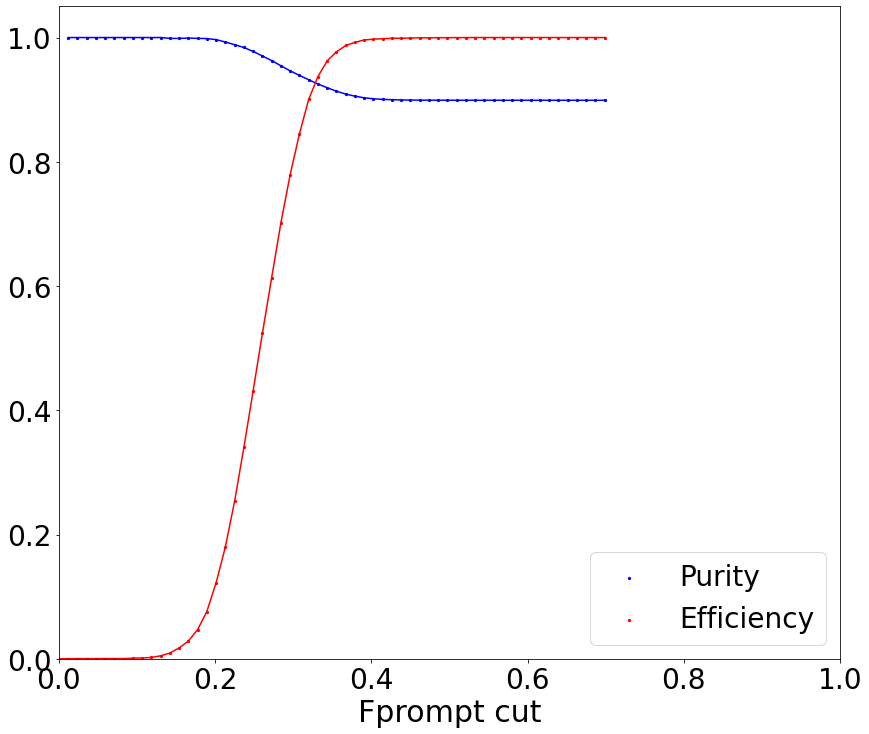

Time window:  100
Purity:  [       nan 0.93211205]
Efficiency:  [0.     0.9003]
Fprompt cut:  [0.         0.31980249]
Signal acceptance:  [0.     0.9003]
Rejection efficiency:  [0.         0.58358192]
Significance:  [        nan 16.29079799]


In [66]:
bin_width = bins_[1] - bins_[0]

purity = np.array([])
efficiency = np.array([])
significance = np.array([])
signal_cut = np.array([])
back_cut = np.array([])

total_sign = bin_width * sum(n_[0])
total_back = bin_width * sum(n_[1])

for i in range(0, bins):
    sign = bin_width * sum(n_[0][0:i])
    back = bin_width * sum(n_[1][0:i])
    purity = np.append(purity, sign/(sign+back))
    efficiency = np.append(efficiency, sign/total_sign)
    signal_cut = np.append(signal_cut, sign/total_sign)
    back_cut = np.append(back_cut, back/total_back)
    significance = np.append(significance, sign/np.sqrt(sign + back))

plt.figure(figsize=(14,12))

sig_label = r'Purity'
bkg_label = r'Efficiency'

plt.scatter(bins_[0:bins], purity, s = 20, label=sig_label, marker='.', color='blue')
plt.plot(bins_[0:bins], purity, color='blue')
plt.scatter(bins_[0:bins], efficiency, s = 20, label=bkg_label, marker='.', color='red')
plt.plot(bins_[0:bins], efficiency, color='red')

idx = np.argwhere(np.diff(np.sign(purity - efficiency))).flatten()
#plt.plot(bins_[0:bins][idx], purity[idx], 'go')

plt.ylabel('', fontsize=30)
plt.xlabel(r'Fprompt cut', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)
plt.ylim(0,1.05)
plt.xlim(0, 1)

plt.show()

print("Time window: ", max_time)
print("Purity: ", purity[idx])
print("Efficiency: ", efficiency[idx])
print("Fprompt cut: ", bins_[0:bins][idx])
print("Signal acceptance: ", signal_cut[idx])
print("Rejection efficiency: ", back_cut[idx])
print("Significance: ", significance[idx])

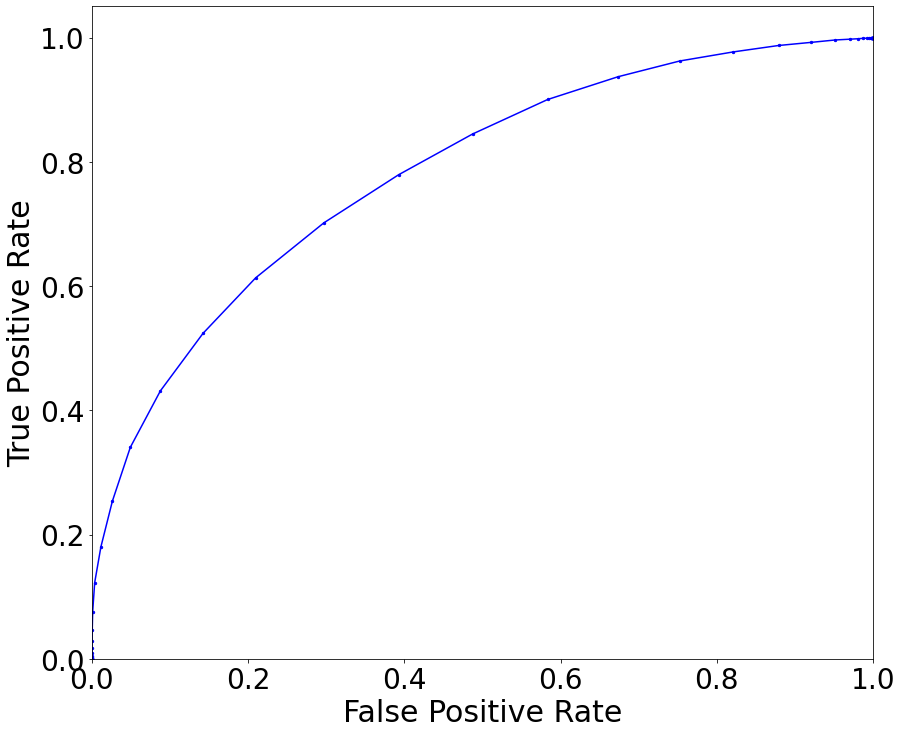

In [67]:
plt.figure(figsize=(14,12))

sig_label = r'Purity'
bkg_label = r'Efficiency'

num_mask = 2000
scint_mask = 1000

plt.scatter(back_cut, signal_cut, s = 22, marker='.', color='blue')
plt.plot(back_cut, signal_cut, color='blue')

plt.ylabel('True Positive Rate', fontsize=30)
plt.xlabel(r'False Positive Rate', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,1.05)
plt.xlim(0,1)

plt.show()

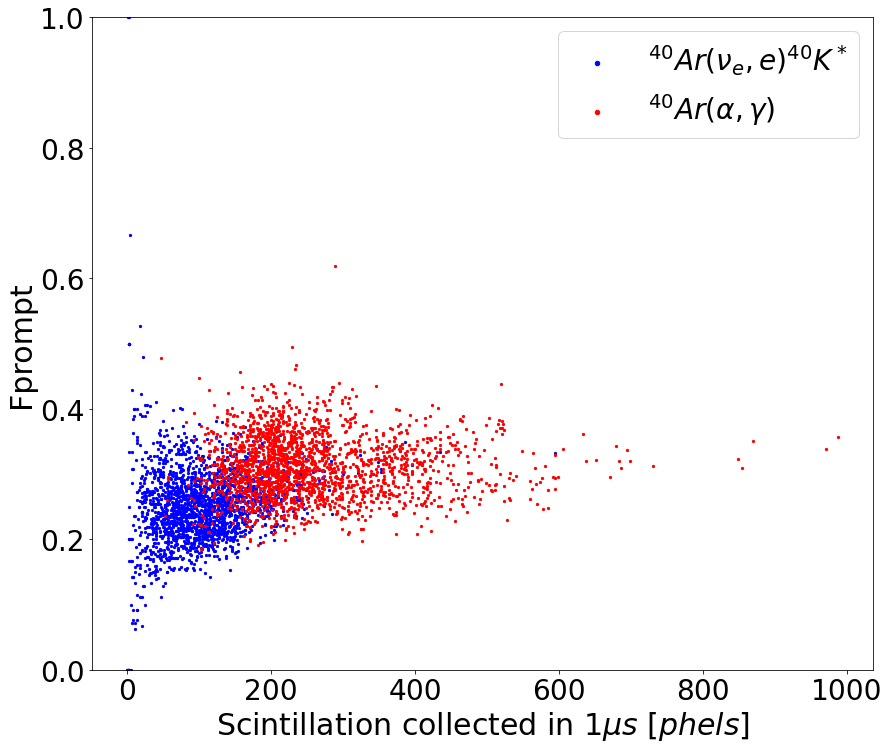

In [49]:
#########################

def scint_timewindow(split_time, set_time):
    #time is in microseconds
    i = 0
    scint_output = np.array([])

    for time in split_time:
        mask = (time <= set_time)
    
        if time.size > 0:
            scint_output = np.append(scint_output, len(time[mask])) # number of photons detected in time window
        i += 1
    
    return scint_output


t_window = 1

signl_wind = scint_timewindow(sig_split_time, t_window)
bkg_wind = scint_timewindow(bkg_split_time, t_window)

#########################

plt.figure(figsize=(14,12))

sig_label = r'${}^{40} Ar(\nu_e, e){}^{40}K^*$'
bkg_label = r'${}^{40} Ar(\alpha, \gamma)$'

num_mask = 2000
scint_mask = 1000

plt.scatter(signl_wind[signl_wind < scint_mask][0:num_mask], Fprompt_sig[signl_wind < scint_mask][0:num_mask], s = 20, label=sig_label, marker='.', color='blue')
plt.scatter(bkg_wind[bkg_wind < scint_mask][0:num_mask], Fprompt_bkg[bkg_wind < scint_mask][0:num_mask], s = 20, label=bkg_label, marker='.', color='red')

plt.ylabel('Fprompt', fontsize=30)
plt.xlabel(r'Scintillation collected in $1 \mu s$ [$phels$]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(markerscale=2, fontsize=28)
plt.ylim(0,1)

plt.show()


ROC curves: Different configs.

In [59]:
back_cut_baseline = [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 1.11114815e-05, 2.22229630e-05, 4.44459260e-05,
 1.22226296e-04, 2.00006667e-04, 3.22232963e-04, 8.33361112e-04,
 1.50005000e-03, 3.65567741e-03, 7.35580075e-03, 1.31559941e-02,
 2.66342211e-02, 4.76904786e-02, 7.87470693e-02, 1.27604253e-01,
 1.87150683e-01, 2.83365001e-01, 3.94813160e-01, 5.13361556e-01,
 6.19631766e-01, 7.20390680e-01, 8.02904541e-01, 8.65106615e-01,
 9.05419070e-01, 9.30208785e-01, 9.44698157e-01, 9.58220830e-01,
 9.67798927e-01, 9.75143616e-01, 9.80988255e-01, 9.85888419e-01,
 9.89677434e-01, 9.92966432e-01, 9.95077614e-01, 9.96933231e-01,
 9.98044379e-01, 9.98844406e-01, 9.99311088e-01, 9.99644433e-01,
 9.99799993e-01, 9.99888885e-01, 9.99966666e-01, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]
signal_cut_baseline = [0. ,        0.01041197, 0.01041197, 0.01041197, 0.0106375,  0.01120132,
 0.01229138, 0.01394527, 0.01593745, 0.0190197,  0.021914,   0.02976996,
 0.03488197, 0.05044354, 0.06788453, 0.08626522, 0.12520674, 0.1694482,
 0.22128251, 0.30273643, 0.38599459, 0.51725304, 0.63813712, 0.75041347,
 0.8308525 , 0.89152007, 0.93001052, 0.95027064, 0.96365208, 0.97147046,
 0.97432717, 0.98534055, 0.98752067, 0.98928733, 0.99045256, 0.99124192,
 0.99173057, 0.99349722, 0.99398587, 0.99439934, 0.99443693, 0.9961284,
 0.99620358, 0.99654187, 0.99654187 ,0.99657946, 0.99718088, 0.99721846,
 0.99721846, 0.99736882, 0.99736882, 0.99759435, 0.99763194, 0.99763194,
 0.99763194, 0.99763194, 0.99763194, 0.99763194, 0.99763194, 0.99763194]


back_cut_foils = [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 2.21212021e-05, 9.95454093e-05 ,4.75605844e-04,
 2.51075643e-03, 1.27086306e-02, 4.19749809e-02, 9.92578337e-02,
 1.91868246e-01, 3.08911526e-01 ,4.35400560e-01, 5.61867472e-01,
 6.76300450e-01, 7.83411311e-01, 8.69805665e-01, 9.33691697e-01,
 9.71131831e-01, 9.88430611e-01, 9.94790457e-01, 9.97279092e-01,
 9.98307728e-01, 9.98728031e-01, 9.98971364e-01, 9.99214697e-01,
 9.99446970e-01, 9.99546515e-01, 9.99635000e-01, 9.99734546e-01,
 9.99767727e-01, 9.99800909e-01, 9.99834091e-01, 9.99867273e-01,
 9.99889394e-01, 9.99933636e-01 ,9.99977879e-01, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]
signal_cut_foils = [0.  ,       0.00440749, 0.00440749, 0.00480817, 0.00550937, 0.00651107,
 0.00761294, 0.0111189  ,0.01412401, 0.02183712, 0.03716318, 0.07262346,
 0.133527  , 0.23890614, 0.36451968, 0.49504157, 0.63988781, 0.75939096,
 0.84944405, 0.91225083, 0.9464089 , 0.97155164, 0.98387258, 0.9888811,
 0.99168587, 0.99429029, 0.99519183, 0.99579285, 0.99599319, 0.99649404,
 0.99659421, 0.99869779, 0.99879796, 0.99879796, 0.99879796, 0.99879796,
 0.99879796, 0.99889813, 0.9989983 , 0.9989983 , 0.9989983 , 0.99939898,
 0.99939898, 0.99939898, 0.99939898, 0.99939898, 0.99939898, 0.99939898,
 0.99939898, 0.99939898, 0.99939898, 0.99939898, 0.99939898, 0.99939898,
 0.99939898, 0.99939898, 0.99939898, 0.99939898, 0.99939898, 0.99939898]



back_cut_foils_40 = [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 1.10485029e-04, 2.20970059e-04, 2.20970059e-04, 5.52425146e-04,
 1.10485029e-03, 3.64600597e-03, 1.16009281e-02, 2.62954370e-02,
 4.92763231e-02, 8.77251132e-02, 1.42304718e-01, 2.09811071e-01,
 2.96983759e-01, 3.92663794e-01, 4.87349464e-01, 5.83581925e-01,
 6.73848194e-01, 7.52734504e-01, 8.21235223e-01, 8.79129378e-01,
 9.20561264e-01, 9.51718042e-01, 9.71163407e-01, 9.81107060e-01,
 9.87736162e-01, 9.92818473e-01, 9.95470114e-01, 9.97237874e-01,
 9.97900784e-01, 9.98342725e-01, 9.98674180e-01, 9.99005635e-01,
 9.99116120e-01, 9.99116120e-01, 9.99116120e-01, 9.99337090e-01,
 9.99447575e-01, 9.99447575e-01, 9.99558060e-01, 9.99558060e-01,
 9.99558060e-01, 9.99668545e-01, 9.99668545e-01, 9.99668545e-01,
 9.99668545e-01, 9.99668545e-01, 9.99779030e-01, 9.99889515e-01]
signal_cut_foils_40 = [0.000e+00, 2.000e-04 ,3.000e-04, 3.000e-04, 3.000e-04, 4.000e-04, 4.000e-04,
 4.000e-04, 9.000e-04, 1.400e-03, 2.100e-03, 4.800e-03, 9.300e-03, 1.750e-02,
 2.850e-02, 4.700e-02, 7.610e-02, 1.225e-01, 1.801e-01, 2.537e-01, 3.404e-01,
 4.312e-01, 5.238e-01, 6.133e-01, 7.017e-01, 7.791e-01, 8.447e-01, 9.003e-01,
 9.370e-01, 9.623e-01, 9.769e-01, 9.872e-01, 9.922e-01, 9.961e-01, 9.974e-01,
 9.981e-01, 9.988e-01, 9.989e-01, 9.992e-01, 9.996e-01, 9.996e-01, 9.998e-01,
 9.998e-01, 9.999e-01, 9.999e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]

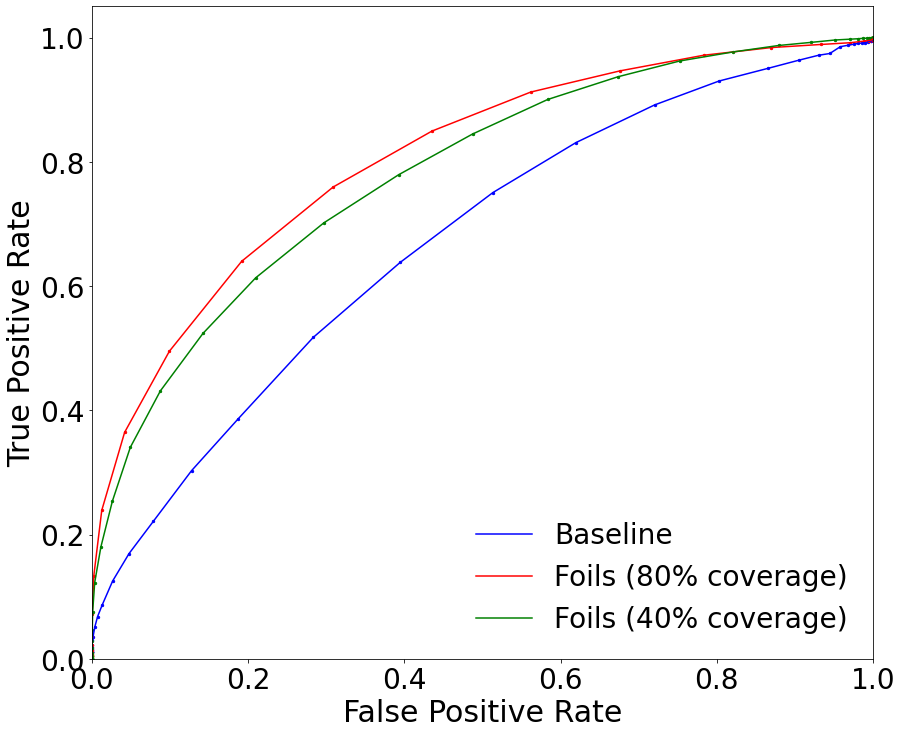

In [61]:
plt.figure(figsize=(14,12))

plt.scatter(back_cut_baseline, signal_cut_baseline, s = 22, marker='.', color='blue')
plt.plot(back_cut_baseline, signal_cut_baseline, color='blue', label='Baseline')

plt.scatter(back_cut_foils, signal_cut_foils, s = 22, marker='.', color='red')
plt.plot(back_cut_foils, signal_cut_foils, color='red', label='Foils (80% coverage)')

plt.scatter(back_cut_foils_40, signal_cut_foils_40, s = 22, marker='.', color='green')
plt.plot(back_cut_foils_40, signal_cut_foils_40, color='green', label='Foils (40% coverage)')

plt.ylabel('True Positive Rate', fontsize=30)
plt.xlabel(r'False Positive Rate', fontsize=30)

#plt.title(r'${}^{40} Ar(\alpha, \gamma), ES\ {}^{8} B$', fontsize=18)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.legend(fontsize=28, frameon=False)

plt.show()